# NumPy and scikit-learn interactions

## ITK and other Python packages

* ITK is great at reading and processing images
* ITK does not show images
* Some algorithms are not available in ITK
* NumPy is great at processing arrays in simple ways
* NumPy arrays can be read by many other Python packages
    * matplotlib
    * scikit-learn

Let's convert an ITK image to a NumPy array

* Load an image with ITK
* Convert the image to a NumPy array
* Check some values in the image

In [1]:
import itk
from itkwidgets import view
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
im=itk.imread("data/KitwareITK.jpg")
arr=itk.array_from_image(im)
print(arr[1,1])


[51 56 60]


Let go the other way around: NumPy array to an ITK image. First, we create an array with some values.

In [3]:
def make_gaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, np.float32)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)


arr = make_gaussian(11)


Let's look at the array. We use matplotlib to do this.

(-0.5, 10.5, 10.5, -0.5)

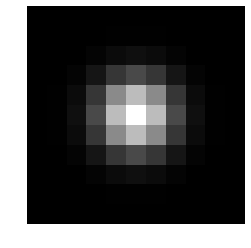

In [4]:
plt.gray()
plt.imshow(arr)
plt.axis('off')

And now, let's convert it to an ITK image.

In [5]:
im = itk.image_view_from_array(arr)

We can now look at pixel values...

In [6]:
im.GetPixel([5,5])

1.0

 or call any ITK filter on the image.

In [7]:
filtered_image=itk.median_image_filter(im, Radius=[2,2])

We can compare some pixel values to see the effect of the filter.

In [8]:
print("Original image pixel value: %f"%im.GetPixel([5,5]))
print("Filtered image pixel value: %f"%filtered_image.GetPixel([5,5]))

Original image pixel value: 1.000000
Filtered image pixel value: 0.291632


Let's modify a pixel in our image, and look at the original array.

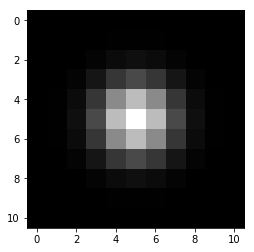

In [9]:
im.SetPixel([5,5], 0)
plt.imshow(arr)


Now let's load an image and show it with matplotlib.

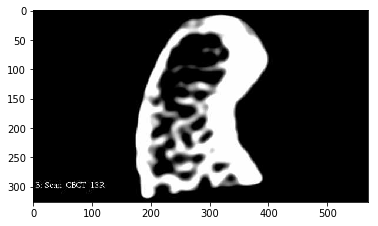

In [10]:
im=itk.imread("data/CBCT-TextureInput.png", itk.UC)
arr = itk.array_view_from_image(im)
plt.imshow(arr)

We can modify a value in the array and look at the value of this pixel in the image.

In [11]:
print("Original image pixel value:%d"%im.GetPixel([270,270]))
arr[270,270] = 0
print("Modified image pixel value:%d"%im.GetPixel([270,270]))

Original image pixel value:146
Modified image pixel value:0


## Views vs copy

So far we have used `itk.array_view_from_image()` and `itk.image_view_from_array()`. You can see the keyword `view` in both the names of these functions.

Let's compare the result of `itk.array_view_from_image()` and `itk.array_from_image()`

Text(0.5, 1.0, 'Copy')

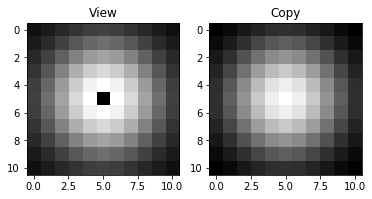

In [12]:
gaussian=itk.gaussian_image_source(Size=11, Sigma=3, Scale=100, Mean=[5,5])
arr_view_gaussian = itk.array_view_from_image(gaussian)
arr_gaussian = itk.array_from_image(gaussian)
gaussian.SetPixel([5,5],0)
plt.subplot(1, 2, 1)
plt.imshow(arr_view_gaussian)
plt.title("View")
plt.subplot(1, 2, 2)
plt.imshow(arr_gaussian)
plt.title("Copy")

The `view` functions does not copy the memory. It shares the same information. In some cases, it is better not to copy the memory (speed, memory limitation). In other cases, it is better to copy the memory (original image needs to be used later)

Copies and views work in both directions: From NumPy to ITK and from ITK to NumPy.

In [13]:
im = itk.image_from_array(arr_gaussian)
im_view = itk.image_view_from_array(arr_gaussian)
arr_gaussian[5,5] = 0
view(im)

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageSS2; proxy of <Swig Object of type 'itkIm…

In [14]:
view(im_view)

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageSS2; proxy of <Swig Object of type 'itkIm…

## Exercises

### Exercise 1: Visualize an image
* Read an image with ITK
* Apply a filter
* Show both original image and filtered images with matplotlib

(-0.5, 569.5, 325.5, -0.5)

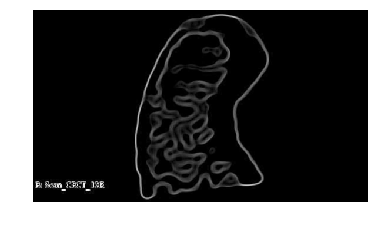

In [26]:
# %load solutions/4_ITK_and_NumPy_answers_Exercise1.py

### Exercise 2: ITK image to NumPy array

* Read an image with ITK
* Convert image to NumPy array
* Modify a pixel in the image
* Has the array been modified?
* Why did you make that choice?

In [29]:
# %load solutions/4_ITK_and_NumPy_answers_Exercise2.py

Pixel in array: 56.000000
Pixel in array: 125.000000
Pixel in image: 56.000000


# ITK Image and NumPy array index order

Let's look at the size of an ITK image and the size of a NumPy array.

In [15]:
im=itk.imread("data/CBCT-TextureInput.png", itk.UC)
arr = itk.array_view_from_image(im)
print("Image size: " + str(itk.size(im)))
print("Array size: " + str(arr.shape))

Image size: itkSize2 ([570, 326])
Array size: (326, 570)


The sizes appear to be inverted!

Let's see what happens if we get the value of a point at a certain location.

In [16]:
print("Pixel value at image location [300,240]:" + str(im.GetPixel([300,240])))
print("Pixel value at array location [300,240]:" + str(arr[300,240]))
print("Pixel value at array location [240,300]:" + str(arr[240,300]))

Pixel value at image location [300,240]:241
Pixel value at array location [300,240]:254
Pixel value at array location [240,300]:241


Indeed, it is inverted. Why?

ITK and NumPy use the opposite convention for their indices order. It is not important when you use filters and work on the image as a whole. The algorithms are aware of the order if they need to.

Could the ITK axes order be kept when converting an image to an array?

Yes. An option is being added to the function `itk.array_from_image()` to keep the axis order.
When *keepAxes* is *False* (default), the NumPy array will have C-order indexing.
This is the reverse of how indices are specified in ITK, i.e. k,j,i versus i,j,k.
However C-order indexing is expected by most algorithms in NumPy / SciPy.

# scikit-learn

* scikit-learn is a machine learning package in Python.
* It is used to illustrate solving a problem using ITK and NumPy arrays.

In [17]:
import sklearn

First, we load 10 2D-images of circles with different radii and center position to which some noise has been added, and their corresponding ground truth segmentations.

Text(0.5, 1.0, 'Image')

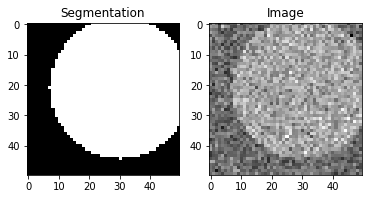

In [18]:
l_label=[]
l_im=[]
for i in range(0,10):
    imageName='data/sklearn/im%d.nrrd'%i
    im=itk.imread(imageName,itk.F)
    arr = itk.array_from_image(im)
    l_im.append(arr)
    labelName='data/sklearn/im%d_label.nrrd'%i
    im=itk.imread(labelName,itk.UC)
    arr = itk.array_from_image(im)
    l_label.append(arr)
size=itk.size(im)
plt.subplot(1, 2, 1)
plt.imshow(l_label[0])
plt.title("Segmentation")
plt.subplot(1, 2, 2)
plt.imshow(l_im[0])
plt.title("Image")

The goal is to find the segmentation based on the input image.

We create arrays of data:
* X - the input samples
* Y - the target values

In [19]:
X0=l_im[0].flatten()
X=X0
Y=l_label[0].flatten()
for i in range(1,10):
    X=np.concatenate((X, l_im[i].flatten()))
    Y=np.concatenate((Y, l_label[i].flatten()))

* We use a supervised learning methods based on applying Bayes’ theorem.
* The only information provided to the algorithm is the image intensity value.

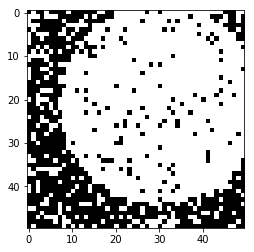

In [20]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(X.reshape(-1,1), Y)
result=clf.predict(X0.reshape(-1,1)).reshape(size[0],size[1])
plt.imshow(result)

To improve our segmentation, we filter the input image with a median image filter and add this information as a second sample vector.

In [21]:
l_median=[]
for i in range(0,10):
    imageName='data/sklearn/im%d.nrrd'%i
    im=itk.imread(imageName,itk.F)
    median=itk.median_image_filter(im, Radius=3)
    arr = itk.array_from_image(median)
    l_median.append(arr)

M0=l_median[0].flatten()
M=M0
X0=np.concatenate((X0.reshape(-1,1),M0.reshape(-1,1)), axis=1)
for i in range(1,10):
    M=np.concatenate((M, l_median[i].flatten()))

X = np.concatenate((X.reshape(-1,1),M.reshape(-1,1)), axis=1)

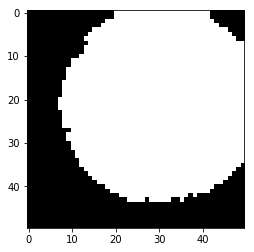

In [22]:
clf.fit(X, Y)
result=clf.predict(X0).reshape(50,50)
plt.imshow(result)

## Typical processing

* Image preprocessing
    * Bias field correction (n4_bias_field_correction_image_filter)
    * Noise reduction (smoothing_recursive_gaussian_image_filter)
    * Feature computation (Texture, Wavelet, Edge detector)
* Converting ITK data to NumPy and organizing the data as needed
* Train classifier
* Use classifier on new data
* Convert classifier result to ITK data
* Apply some post processing filters
    * Fill holes (binary_fillhole_image_filter)
    * Smoothing (median_image_filter)

### Enjoy ITK!